# Evaluating an SSH Mapping algorithm using OceanBench and 4dvarnet-starter

## Overview
In this notebook we show how to:
- install necessary package
- download necessary data from the data-registry using dvc
- use oceanbench to format and create pytorch dataloading utils
- use 4dvarnet-starter to instantiate a training pipeline
- use oceanbench to visualize the results and compute metrics
- orchestrate all of this using hydra

## Setup

### Download source from github
 - **oceanbench-data-registry**: data-registry for versioning and accessing your ocean datasets everywhere
 - **4dvarnet-starter**: implementation of the 4dvarnet algorithm using pytorch lightning
 - **oceanbench**: all necessary tools to setup and evaluate a machine learning pipeline using ocean data

In [2]:
cd /content

/content


In [3]:
!git clone https://github.com/CIA-Oceanix/4dvarnet-starter.git
!git clone https://github.com/quentinf00/oceanbench-data-registry.git
!git clone https://github.com/jejjohnson/oceanbench.git


fatal: destination path '4dvarnet-starter' already exists and is not an empty directory.
fatal: destination path 'oceanbench-data-registry' already exists and is not an empty directory.
fatal: destination path 'oceanbench' already exists and is not an empty directory.


In [4]:
%cd 4dvarnet-starter
!git pull --tags
!git checkout patch200
%cd ..

/content/4dvarnet-starter
You are not currently on a branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

HEAD is now at 968306c Setup fit /raid/localscratch/qfebvre/4dvarnet-starter/outputs/2023-05-12/17-55-29/base/
/content


### Install python packages

In [5]:
!pip install --quiet condacolab einops pytorch-lightning cmocean pint-xarray numpy_groupies loguru torchaudio cffi==1.15.1
import condacolab
condacolab.install()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
!mamba env update --quiet -f oceanbench/environments/linux.yaml
!mamba install --quiet -c conda-forge  -c pyviz kornia metpy xrft pyinterp funcy=1.18 fsspec=2022.11.0 dvc-s3=2.21.0 hvplot gcm_filters xesmf

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Installing pip dependencies: ...working... done


In [7]:
!pip install "git+https://github.com/jejjohnson/ocn-tools.git"
!pip uninstall xarray-dataclasses -y
!pip install xarray -U -y

  Cloning https://github.com/jejjohnson/ocn-tools.git to /tmp/pip-req-build-xp11sg0p
  Running command git clone --filter=blob:none --quiet https://github.com/jejjohnson/ocn-tools.git /tmp/pip-req-build-xp11sg0p
  Resolved https://github.com/jejjohnson/ocn-tools.git to commit de16a95ead152db25346eaaa73cad51930335372
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 13.8 MB/s eta 0:00:00
  Using cached xesmf-0.7.1-py3-none-any.whl (41 kB)
  Using cached numpy_groupies-0.9.22-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 21.8 MB/s eta 0:00:00
  Using cached cmake-3.18.4.post1-py3-none-manylinux1_x86_64.whl (17.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.1 MB/s eta 0:00:00
  Using cached rootutils-1.0.7-py3-none-any.whl (6.4 kB)
  Using cached xrft-1.0.1-py2.py3-none-any.whl (32 kB)
  Using cache

### Download data from data registry using dvc
Files:
- **osse_natl60/grid/gf_mod_ssh_daily.nc**: 1 year daily average from NATL60 simulation over gulfstream
- **osse_natl60/grid/gf_obs_nadir.nc**: nadir pseudo-observations sampled from the NATL60 simulation
- **results/osse_gf_nadir/duacs.nc**: Optimal interpolation based DUACS products made from above pseudo-observations


In [8]:
%cd oceanbench-data-registry
!dvc pull --quiet -j3 osse_natl60/grid/gf_obs_nadir.nc osse_natl60/grid/gf_mod_ssh_daily.nc results/osse_gf_nadir/duacs.nc
%cd ..


/content/oceanbench-data-registry
/content


## Get ocean bench task data

**Below is an example on how to load and each file with correct preprocessing**

In [9]:
pwd

'/content'

In [10]:
import sys
sys.path.append('oceanbench')
sys.path.append('4dvarnet-starter')

In [11]:
%env ESMFMKFILE /usr/local/envs/oceanbench/lib/esmf.mk
%env PROJ_DATA /usr/local/envs/oceanbench/share/proj


env: ESMFMKFILE=/usr/local/envs/oceanbench/lib/esmf.mk
env: PROJ_DATA=/usr/local/envs/oceanbench/share/proj


In [12]:
import hydra
from omegaconf import OmegaConf
import hydra
with hydra.initialize('oceanbench/config', version_base='1.3'):
    cfg = hydra.compose('main', overrides=[
        'task=[osse_gf_nadir/task,osse_gf_nadir/results,osse_gf_nadir/leaderboard]',
            'task.data.domain=gf', # We downloaded the reduced dataset,
            'task.data.base_dir=/content/oceanbench-data-registry/osse_natl60/grid', # We need to update the path
            'results.base_dir=/content/oceanbench-data-registry/results/osse_gf_nadir', # We need to update the path
        ])
task = hydra.utils.call(cfg.task.outputs)
results = hydra.utils.call(cfg.results.outputs)
print(f"\n{task.data.ssh()=}")
print(f"\n{task.data.obs()=}")


task.data.ssh()=<xarray.DataArray 'ssh' (time: 365, lat: 201, lon: 201)>
[14746365 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01T12:00:00 ... 2013-09-30T12:00:00
Attributes:
    units:          m
    standard_name:  sea_surface_height
    long_name:      Sea Surface Height

task.data.obs()=<xarray.DataArray 'ssh_mod' (time: 365, lat: 201, lon: 201)>
[14746365 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Attributes:
    units:          m
    standard_name:  sea_surface_height
    long_name:      Sea Surface Height



### From task data to Patcher


In [13]:
import importlib
import xrpatcher
import xarray as xr

def patcher_from_osse_task(task, patcher_kw, ref_var='ssh', split='trainval'):
    default_domain_limits = dict(
        time=slice(*task.splits[split]),
        lat=slice(*task.domain.lat),
        lon=slice(*task.domain.lon)
    )
    domain_limits = {**default_domain_limits, **patcher_kw.get('domain_limits', {})}
    task_data = {k: v().sel(domain_limits) for k, v in task.data.items()}

    da = xr.Dataset(
        {
            k: v.assign_coords(task_data[ref_var].coords)
            if k!=ref_var else v
            for k, v in task_data.items()
        }
    ).to_array()
    return xrpatcher.XRDAPatcher(da, **patcher_kw)

patcher_kw = dict(patches={'time': 15, 'lat': 200, 'lon': 200}, strides={'time': 1, 'lat': 200, 'lon': 200})

train_kw = dict(**patcher_kw, domain_limits=dict(time=slice('2013-02-24', '2013-09-30'), lat=slice(33, 42.95), lon=slice(-65, -55.05)))
val_kw = dict(**patcher_kw, domain_limits=dict(time=slice('2012-01-01', '2013-02-24'), lat=slice(33, 42.95), lon=slice(-65, -55.05)))
test_kw = dict(**patcher_kw, domain_limits=dict(time=slice('2012-10-01', '2012-12-20'), lat=slice(33, 42.95), lon=slice(-65, -55.05)))

train_patcher = patcher_from_osse_task(task, train_kw)
val_patcher = patcher_from_osse_task(task, val_kw)
test_patcher = patcher_from_osse_task(task, test_kw, split='test')
print('\nTrain', train_patcher, '\n')
print('\nVal', val_patcher, '\n')
print('\nTest', test_patcher, '\n')


Train XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 219), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 15), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 200), ('lon', 200)])
Num Items:    OrderedDict([('variable', 1), ('time', 205), ('lat', 1), ('lon', 1)]) 


Val XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 147), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 15), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 200), ('lon', 200)])
Num Items:    OrderedDict([('variable', 1), ('time', 133), ('lat', 1), ('lon', 1)]) 


Test XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 81), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 15), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time'

### Torch Dataset and DataLoader
For training a model using pytorch one need two elements:
- a `torch.utils.data.Dataset` that returns a single instance of what the model needs for training
- a `torch.utils.data.DataLoader` that returns a batch which are of return values of the dataset stacked along the first dimensions

The  `Lit4VarNet` pytorch_lightning.LightningModule defined in the `4dvarnet-starter/src/models.py` needs an batch with `tgt` and `input` attributes corresponding to spatio-temporal patches of target ssh and input observations

Below we define:
- a `XrTorchDataset` that is mainly a wrapper over the `XRDABatcher`
- a `create_dataloaders`:
    - that takes as input instances of XrTorchDataset and assign the processing steps to be appled on each item:
        - normalize the data using the training statistics
        - convert the data precision to 32 bit floating
        - split the three fields of an item ( obs, ssh, oi) into a `TrainingItem` which is a namedtuple with the `tgt` and `input` attributes (and `baseline` attribute that won't be used during training but for evaluation)
    - instantiate and return three dataloaders for each datasets using the `dl_kws` argument




In [14]:
import torch
import itertools

class XrTorchDataset(torch.utils.data.Dataset):
    def __init__(self, patcher: xrpatcher.XRDAPatcher, item_postpro=None):
        self.patcher = patcher
        self.postpro = item_postpro

    def __getitem__(self, idx):
        item = self.patcher[idx].load().values
        if self.postpro:
            item = self.postpro(item)
        return item

    def reconstruct_from_batches(self, batches, **rec_kws):
        return self.patcher.reconstruct([*itertools.chain(*batches)], **rec_kws)

    def __len__(self):
        return len(self.patcher)


In [15]:
import collections
import numpy as np
import oceanbench._src.utils.hydra

TrainingItem = collections.namedtuple('TrainingItem', ('input', 'tgt'))
DataLoaders = collections.namedtuple('DataLoaders', ('train_dl', 'val_dl', 'test_dl'))

def norm_stats(ds):
    return ds.patcher.da.sel(variable='ssh').pipe(
        lambda da: (da.mean().item(), da.std().item())
    )
def create_dataloaders(train_ds: XrTorchDataset, val_ds: XrTorchDataset, test_ds: XrTorchDataset, dl_kws):
        m, s =  norm_stats(train_ds)
        train_ds.postpro, val_ds.postpro, test_ds.postpro = [
            lambda item: oceanbench._src.utils.hydra.pipe(item, [
                lambda i: (i - m) / s,
                lambda i: i.astype(np.float32),
                TrainingItem._make, # /!\ order of first dim must be same as order of tuple component
        ])]*3

        return DataLoaders(
            train_dl=torch.utils.data.DataLoader(train_ds, shuffle=True, **dl_kws),
            val_dl=torch.utils.data.DataLoader(val_ds, shuffle=False, **dl_kws),
            test_dl=torch.utils.data.DataLoader(test_ds, shuffle=False, **dl_kws)
        )

dataloaders = create_dataloaders(
    XrTorchDataset(train_patcher),
    XrTorchDataset(val_patcher),
    XrTorchDataset(test_patcher),
    dl_kws=dict(batch_size=4)
)
batch = next(iter(dataloaders.train_dl))
print(f"{type(batch)=},\n{type(batch.input)=},\n {batch.input.shape=}")

type(batch)=<class '__main__.TrainingItem'>,
type(batch.input)=<class 'torch.Tensor'>,
 batch.input.shape=torch.Size([4, 15, 200, 200])


## Configure the 4dVarNet LightningModule (with hydra)
The 4dvarnet-starter project defines the necessary classes to train a 4dvarnet model using pytorch lightning:
- The `Lit4VarNet` specify the training and validation steps (training losses and metrics)
- The solver is the core 4dVarNet model which consist in:
    - a iterative solver which performs the variational cost minimization (`GradSolver`)
    - the variational cost is composed of:
        - an observation cost `BaseObsCost`
        - a prior cost `BilinAePriorCost`
    - a the state update during the minimization is done thanks to a gradient model `ConvLstmGradModel`

We define all the parameters of the different classes using hydra and are able to instantiate the model with `hydra.call`
We use the parameters corresponding to the pretrained model weights available here: https://s3.eu-central-1.wasabisys.com/melody/quentin_cloud/starter_jobs/patch200/config.yaml

In [16]:
import src.models as fourdvarnet
import src.utils as fourdvarnet_utils

prior_cost = fourdvarnet.BilinAEPriorCost(
    dim_in=patcher_kw['patches']['time'],
    dim_hidden=64,
    downsamp=2,
)
grad_mod = fourdvarnet.ConvLstmGradModel(
    dim_in=patcher_kw['patches']['time'],
    dim_hidden=96,
)
obs_cost = fourdvarnet.BaseObsCost()

solver = fourdvarnet.GradSolver(
    n_step=12, lr_grad=100, prior_cost=prior_cost, obs_cost=obs_cost, grad_mod=grad_mod
)

lit_mod = fourdvarnet.Lit4dVarNet(
    opt_fn=lambda m: torch.optim.Adam(m.parameters()),
    rec_weight=fourdvarnet_utils.get_triang_time_wei(patch_dims = patcher_kw['patches'], crop=dict(lat=5, lon=5), offset=0),
    solver=solver
)

lit_mod = lit_mod.to('cuda')
batch = lit_mod.transfer_batch_to_device(batch, lit_mod.device, 0)
with torch.no_grad():
    lit_mod = lit_mod.eval()
    print(f"\n{lit_mod(batch).shape=}")


lit_mod(batch).shape=torch.Size([4, 15, 200, 200])


In [17]:
!wget -nc https://s3.eu-central-1.wasabisys.com/melody/quentin_cloud/starter_jobs/patch200/checkpoints/val_rmse=0.0198-epoch=091.ckpt

--2023-10-09 14:07:03--  https://s3.eu-central-1.wasabisys.com/melody/quentin_cloud/starter_jobs/patch200/checkpoints/val_rmse=0.0198-epoch=091.ckpt
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.34, 130.117.252.19, 130.117.252.22, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11376598 (11M) [binary/octet-stream]
Saving to: ‘val_rmse=0.0198-epoch=091.ckpt’

val_rmse=0.0198-epo 100%[===================>]  10.85M  5.50MB/s    in 2.0s    

2023-10-09 14:07:06 (5.50 MB/s) - ‘val_rmse=0.0198-epoch=091.ckpt’ saved [11376598/11376598]



## Diagnostics


### Using the pre-trained model to reconstruct the SSH field
- Using pytorch lightning, we can easily generate the predictions for each batch using the `trainer.predict` api
- We can leverage oceanbench's `XRDABatcher.reconstruct`italicized text to stitch merge together the different batches by providing
    - a list of tensor, in the same order of the batcher items
    - the name of the dimensions: common dimensions names with the batcher data will be matched with the coordinates of the items
    - in case of overlap, the `weight` parameter will be used to determine how to weight each value at the same position



In [18]:
import pytorch_lightning as pl
trainer = pl.Trainer(accelerator='gpu', devices=1, inference_mode=False)
predictions = trainer.predict(lit_mod, dataloaders=dataloaders.test_dl, ckpt_path='val_rmse=0.0198-epoch=091.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
Restoring states from the checkpoint path at val_rmse=0.0198-epoch=091.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at val_rmse=0.0198-epoch=091.ckpt


Predicting: 0it [00:00, ?it/s]

In [19]:
type(predictions[0]), predictions[0].shape

(torch.Tensor, torch.Size([4, 15, 200, 200]))

In [20]:
m, s = norm_stats(dataloaders.train_dl.dataset)
rec_ds = dataloaders.test_dl.dataset.reconstruct_from_batches(
    predictions,
    dims_labels=('time', 'lat', 'lon'),
    weight=lit_mod.rec_weight.data.cpu().numpy()
).pipe(lambda da: (da * s) + m ).to_dataset(name='ssh')

100%|██████████| 67/67 [00:02<00:00, 23.88it/s]


In [21]:

m, s

(0.33698271061384827, 0.39459587604848406)

In [22]:
rec_ds.to_netcdf('predictions.nc')

### Compute the task metrics

In [23]:
import pandas as pd

cfg.method='4dvarnet'
cfg.outputs.summary.method='4dvarnet'
cfg.results.outputs.eval.methods['4dvarnet'].inp = 'predictions.nc'
lb = hydra.utils.call(cfg.outputs)
eval_ds = lb.build_eval_ds().isel(lat=slice(10, -10), lon=slice(10, -10))#.assign(study=lambda ds: ((ds.study - ds.study.mean()) /ds.study.std()) * ds.ref.std() + ds.ref.mean())
score = pd.Series({k: v(eval_ds) if callable(v) else v for k,v in lb.summary.items()})
print(score.to_frame(name='Summary').T.to_markdown())


|         |   nrmse | lambda_x_isotrop   | lambda_x_spacetime   | lambda_t_spacetime   | method   | task                         |
|:--------|--------:|:-------------------|:---------------------|:---------------------|:---------|:-----------------------------|
| Summary |   0.945 | 64.63 km           | 95.26 km             | 5.05 days            | 4dvarnet | DC2020 OSSE Gulfstream Nadir |


In [24]:

cfg.method='duacs'
cfg.outputs.summary.method='duacs'

lb = hydra.utils.call(cfg.outputs)
eval_ds = lb.build_eval_ds().isel(lat=slice(5, -5), lon=slice(5, -5))
baseline_score = pd.Series({k: v(eval_ds) if callable(v) else v for k,v in lb.summary.items()})
print(pd.DataFrame([score, baseline_score]).to_markdown())


|    |   nrmse | lambda_x_isotrop   | lambda_x_spacetime   | lambda_t_spacetime   | method   | task                         |
|---:|--------:|:-------------------|:---------------------|:---------------------|:---------|:-----------------------------|
|  0 |   0.945 | 64.63 km           | 95.26 km             | 5.05 days            | 4dvarnet | DC2020 OSSE Gulfstream Nadir |
|  1 |   0.916 | 119.60 km          | 171.97 km            | 11.11 days           | duacs    | DC2020 OSSE Gulfstream Nadir |


### Visualize the maps

:Layout
   .Overlay.I    :Overlay
      .Image.I    :Image   [lon,lat]   (study)
      .Contours.I :Contours   [lon,lat]   (study)
   .Overlay.II   :Overlay
      .Image.I    :Image   [lon,lat]   (ref)
      .Contours.I :Contours   [lon,lat]   (ref)
   .Overlay.III  :Overlay
      .Image.I    :Image   [lon,lat]   (study)
      .Contours.I :Contours   [lon,lat]   (study)
   .Overlay.IV   :Overlay
      .Image.I    :Image   [lon,lat]   (ref)
      .Contours.I :Contours   [lon,lat]   (ref)
   .Overlay.V    :Overlay
      .Image.I    :Image   [lon,lat]   (study)
      .Contours.I :Contours   [lon,lat]   (study)
   .Overlay.VI   :Overlay
      .Image.I    :Image   [lon,lat]   (ref)
      .Contours.I :Contours   [lon,lat]   (ref)
   .Overlay.VII  :Overlay
      .Image.I    :Image   [lon,lat]   (study)
      .Contours.I :Contours   [lon,lat]   (study)
   .Overlay.VIII :Overlay
      .Image.I    :Image   [lon,lat]   (ref)
      .Contours.I :Contours   [lon,lat]   (ref)
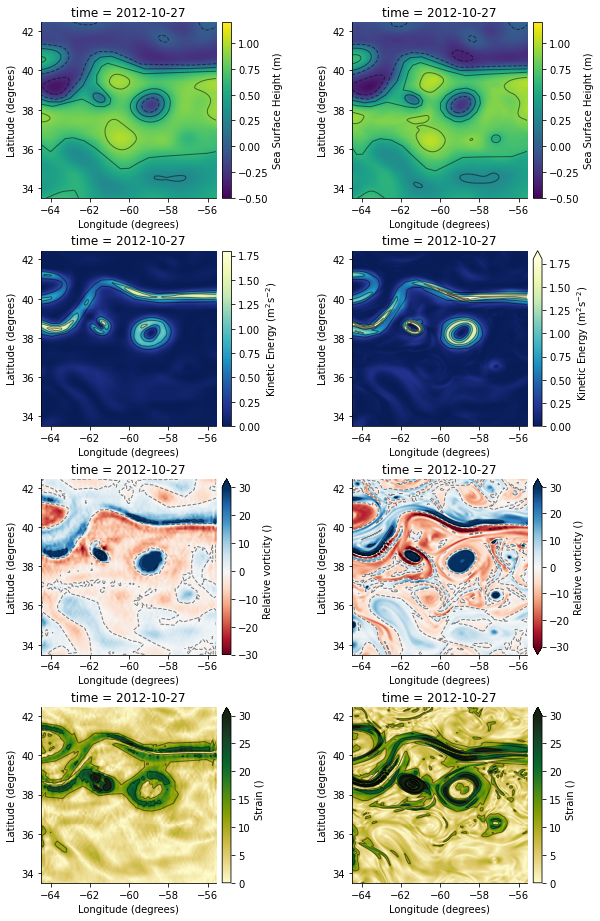

In [25]:
cfg.method='4dvarnet'
cfg.results.outputs.plots.maps.methods['4dvarnet'].inp = 'predictions.nc'
lb = hydra.utils.call(cfg.outputs)
plot_ds = lb.plots.build_ds.maps().isel(lat=slice(10, -10), lon=slice(10, -10))

import functools
import operator
import hvplot
import hvplot.xarray
hvplot.extension('matplotlib')
functools.reduce(operator.add, [p(plot_ds) for p in lb.plots.maps.values()]).opts(shared_axes=False, sublabel_format='').cols(2)